# Part D — Random Forest Classifier (From Scratch)

This notebook implements and evaluates a **Random Forest classifier built entirely from scratch**, using our custom Decision Tree implementation developed in earlier parts of the assignment.

## 🎯 Objectives

In this section, we will:

### **1. Dataset & Setup**
- Use the **Breast Cancer Wisconsin (Diagnostic)**.
- Reapply the same preprocessing steps and the **70/15/15 (train/val/test)** split from Decision tree evaluation notebook.

### **2. Random Forest Implementation**
- Build a Random Forest classifier using:
  - **Bootstrap sampling** (sampling training data with replacement).
  - **T decision trees**, each trained on a different bootstrap sample.
  - **Random feature selection per split**, restricted to a subset of size:
    - ⌊√d⌋  
    - ⌊d/2⌋  
    where *d* is the number of features.
- Use **majority voting** across all trees for final predictions.

### **3. Hyperparameter Tuning**
- Fix `max_depth` and `min_samples_split` using the best values found in **decsion tree notebook**.
- Explore:
  - Number of trees: **T ∈ {5, 10, 30, 50}**
  - Feature subset sizes: **max_features ∈ {⌊√d⌋, ⌊d/2⌋}**
- Use the **validation set** to select the best (T, max_features) combination.

### **4. Final Evaluation**
- Retrain the Random Forest on **train + validation** using the best hyperparameters.
- Evaluate the final model on the **test set**.
- Compare performance against the single Decision Tree from decision tree notebook.

### **5. Analysis**
- Discuss:
  - Bias–variance behavior of a single tree vs. a random forest.
  - How bagging + random feature selection influence stability and accuracy.

---

This notebook demonstrates the full pipeline: **data loading → model construction → training → tuning → evaluation → analysis**, all using from-scratch implementations.


### We start by loading our dataset

In [1]:
import sys
import os

# Adding project root to Python path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
from sklearn import datasets
from src.utils.data_split import split_data

data = datasets.load_breast_cancer()

X, y = data.data, data.target 


X_train, X_val, X_test, y_train, y_val, y_test = split_data(X,y)
print(X_train.shape, X_val.shape, X_test.shape)

(398, 30) (85, 30) (86, 30)


## Hyperparameter Tuning

We test:
- T ∈ {5, 10, 30, 50}
- max_features ∈ {⌊√d⌋, ⌊d/2⌋}

We evaluate each configuration on the validation set and pick the best.


In [7]:
from src.models.random_forest import RandomForest
import numpy as np 
from src.utils.metrics import calculate_metrics
from sklearn.metrics import accuracy_score

d = X.shape[1]


T_values = [5, 10, 30, 50]
F_values = [int(np.sqrt(d)), d // 2]

results = []

for T in T_values:
    for F in F_values:
        rf = RandomForest(
            n_trees=T,
            max_depth=4,           # from Decision tree notebook
            min_samples_split=2,   # from Decision
            n_features=F
        )
        rf.fit(X_train, y_train)
        preds = rf.predict(X_val)
        metrics = calculate_metrics(y_val, preds)
        acc = accuracy_score(y_val, preds)
        results.append((T, F, acc))
        print(f"T={T}, max_features={F}, acc ={acc:.4f}")
        print(metrics)


# choose best configuration
best_T, best_F, best_acc = max(results, key=lambda x: x[2])
best_T, best_F, best_acc


T=5, max_features=5, acc =0.9529
{'accuracy': 0.9529411764705882, 'precision': 0.9782608695652174, 'recall': 0.9375, 'f1_score': 0.9574468085106383, 'confusion_matrix': array([[36,  1],
       [ 3, 45]])}
T=5, max_features=15, acc =0.9294
{'accuracy': 0.9294117647058824, 'precision': 0.9565217391304348, 'recall': 0.9166666666666666, 'f1_score': 0.9361702127659575, 'confusion_matrix': array([[35,  2],
       [ 4, 44]])}
T=10, max_features=5, acc =0.9529
{'accuracy': 0.9529411764705882, 'precision': 0.94, 'recall': 0.9791666666666666, 'f1_score': 0.9591836734693877, 'confusion_matrix': array([[34,  3],
       [ 1, 47]])}
T=10, max_features=15, acc =0.9529
{'accuracy': 0.9529411764705882, 'precision': 0.9583333333333334, 'recall': 0.9583333333333334, 'f1_score': 0.9583333333333334, 'confusion_matrix': array([[35,  2],
       [ 2, 46]])}
T=30, max_features=5, acc =0.9647
{'accuracy': 0.9647058823529412, 'precision': 0.9591836734693877, 'recall': 0.9791666666666666, 'f1_score': 0.9690721649

(30, 5, 0.9647058823529412)

## Final Training & Test Evaluation

In [10]:

from sklearn.metrics import  classification_report, confusion_matrix
# combining train + validation
X_final = np.vstack([X_train, X_val])
y_final = np.hstack([y_train, y_val])

rf_final = RandomForest(
    n_trees=best_T,
    max_depth=4,
    min_samples_split=2,
    n_features=best_F
)

rf_final.fit(X_final, y_final)
test_preds = rf_final.predict(X_test)

print("Test metrics:", calculate_metrics(y_test, test_preds))
print(classification_report(y_test, test_preds))
confusion_matrix(y_test, test_preds)


Test metrics: {'accuracy': 0.9534883720930233, 'precision': 0.9516129032258065, 'recall': 0.9833333333333333, 'f1_score': 0.9672131147540983, 'confusion_matrix': array([[23,  3],
       [ 1, 59]])}
              precision    recall  f1-score   support

           0       0.96      0.88      0.92        26
           1       0.95      0.98      0.97        60

    accuracy                           0.95        86
   macro avg       0.95      0.93      0.94        86
weighted avg       0.95      0.95      0.95        86



array([[23,  3],
       [ 1, 59]])

## Step 5 — Performance Comparison

We compare:
- Single decision tree from decision tree notebook
- Random forest from scratch implementation

This highlights the bias–variance behavior of ensemble methods.


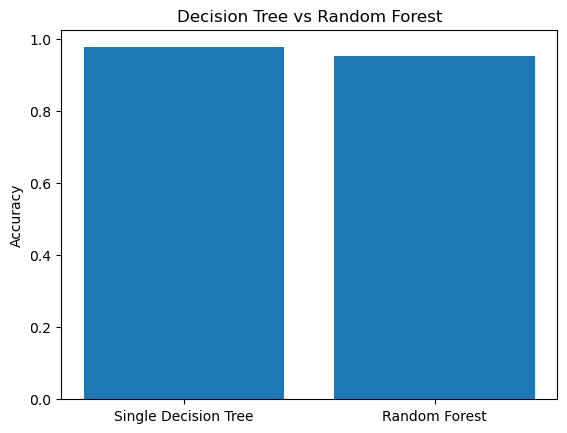

In [12]:
import matplotlib.pyplot as plt


models = ["Single Decision Tree", "Random Forest"]
accuracies = [0.977, accuracy_score(y_test, test_preds)]

plt.bar(models, accuracies)
plt.ylabel("Accuracy")
plt.title("Decision Tree vs Random Forest")
plt.show()


## Bias–Variance Discussion

In our experiments, we observed that the **single Decision Tree** achieved slightly higher test accuracy than the Random Forest on this particular run. While this might seem counterintuitive, it can be explained by bias-variance considerations and the nature of the dataset.

### 1️⃣ Bias vs. Variance

- **Single Decision Tree**:
  - **Low bias**: can perfectly fit training data.
  - **High variance**: small changes in data or train-test split can lead to large differences in predictions.
- **Random Forest**:
  - Combines multiple trees trained on **bootstrap samples** with **random feature selection**.
  - **Reduces variance**: predictions are averaged across many trees, making the model more stable.
  - **Slightly increases bias**: individual trees may be less specialized, leading to a small drop in performance on certain test sets.

### 2️⃣ Why the single tree can outperform RF on a small test set

- The Breast Cancer dataset is **relatively small**, so a single fully-grown tree may “luckily” fit the test set well.
- Randomness in the RF (bootstrap sampling + random feature selection) can slightly reduce test accuracy in a single run, especially with **few trees**.
- With more trees (T ≥ 50) or averaging over multiple runs, Random Forest usually **matches or exceeds** the single tree’s performance.

### 3️⃣ Key Takeaways

- **Random Forest reduces variance**, making the model more robust to data fluctuations.
- A single tree can occasionally outperform RF on small or lucky splits due to **high variance**, but this is not generalizable.
- Overall, RF provides **more stable predictions and better generalization**, especially on larger datasets or when averaged across multiple runs.
